In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import tessreduce as tr

made reference
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction


<IPython.core.display.Javascript object>


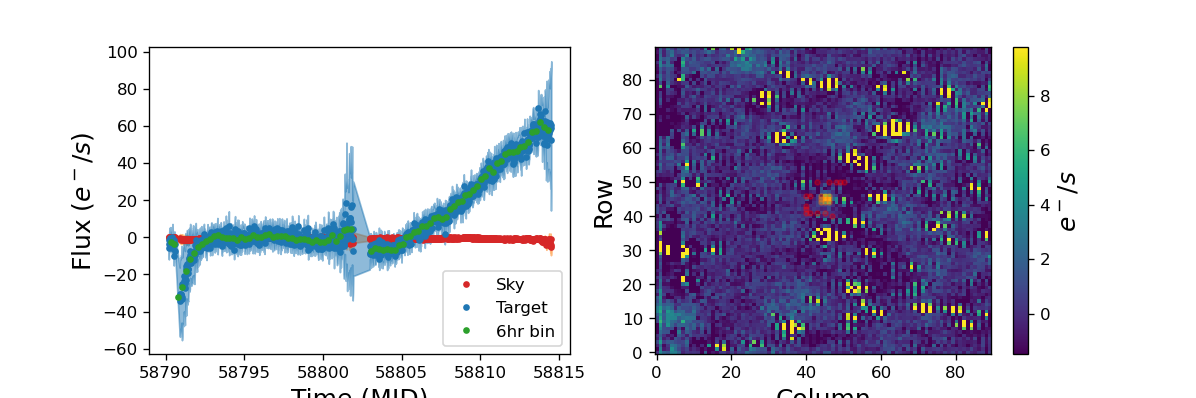

In [2]:
tess = tr.tessreduce(tpf='../../SN_individual/2019vxm/s18.fits',calibrate=False)

<IPython.core.display.Javascript object>


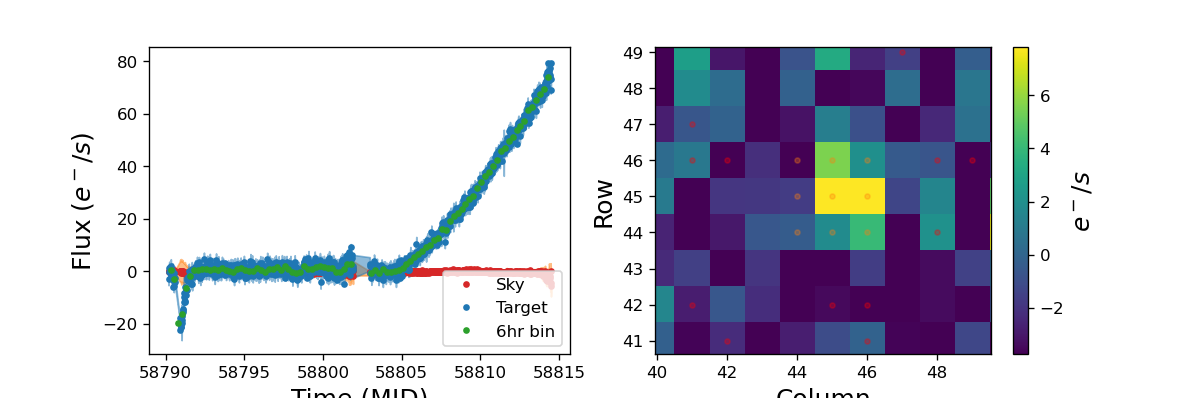

In [3]:
lc,s = tess.diff_lc(phot_method='psf',plot=True);

In [5]:
lc2,s = tess.diff_lc(phot_method='psf',psf_snap='all',plot=True);

ValueError: zero-size array to reduction operation maximum which has no identity

In [2]:
obs = tr.sn_lookup('sn2019vxm')

|   Sector | Covers   |   Time difference  |
|          |          |             (days) |
|----------+----------+--------------------|
|       14 | False    |               -108 |
|       15 | False    |                -81 |
|       16 | False    |                -55 |
|       17 | False    |                -29 |
|       18 | False    |                 -4 |
|       21 | False    |                 51 |
|       24 | False    |                137 |
|       41 | False    |                600 |
|       47 | False    |                760 |
|       48 | False    |                789 |
|       51 | False    |                873 |
|       54 | False    |                951 |
|       55 | False    |                978 |
|       56 | False    |               1005 |
|       57 | False    |               1034 |
|       58 | False    |               1063 |
|       60 | False    |               1118 |
|       74 | False    |               1494 |
|       75 | False    |               1521 |
|       76

getting TPF from TESScut
made reference
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction


<IPython.core.display.Javascript object>


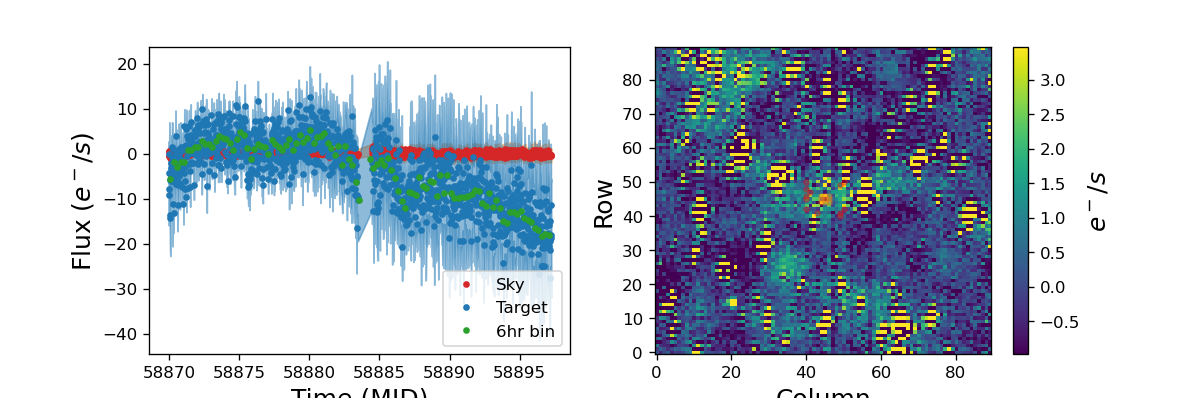

In [3]:
tess = tr.tessreduce(obs_list=obs[5],calibrate=False)

<IPython.core.display.Javascript object>


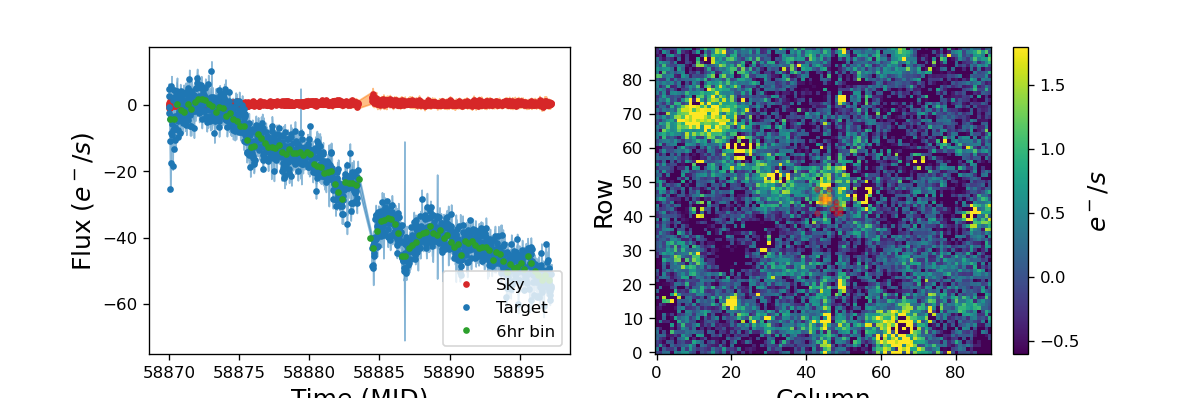

In [4]:
lc,s = tess.diff_lc(phot_method='psf',plot=True);

<IPython.core.display.Javascript object>


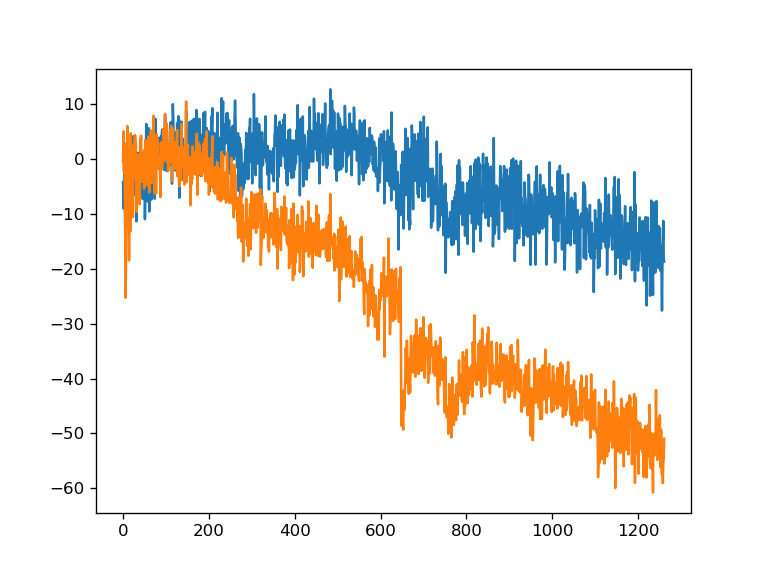

In [6]:
plt.figure()
plt.plot(tess.lc[1])
plt.plot(lc[1])
#plt.fill_between(lc[0],lc[1]-lc[2],lc[1]+lc[2],color='C1',alpha=0.5)


<IPython.core.display.Javascript object>


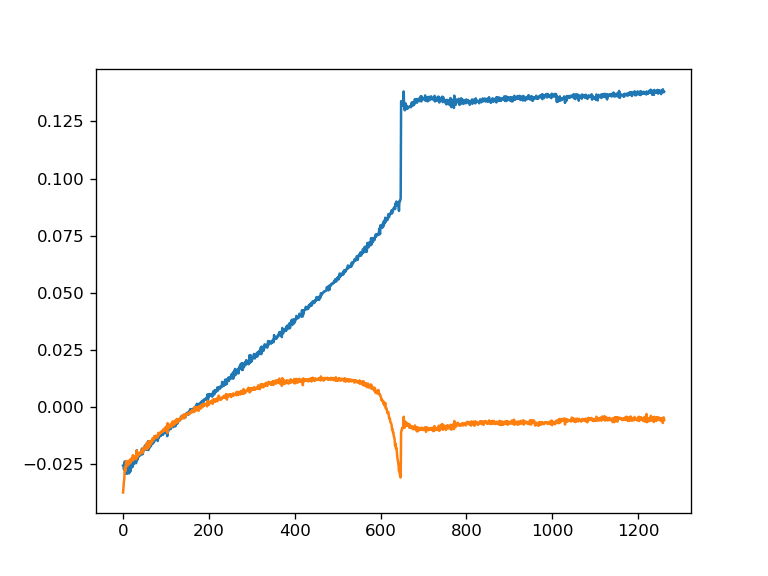

In [34]:
plt.figure()
plt.plot(tess.shift[:,0])
plt.plot(tess.shift[:,1])

In [7]:
size = 7
prf, cutouts = tess._psf_initialise(size,(45,45))   # gather base PRF and the array of cutouts data

<IPython.core.display.Javascript object>


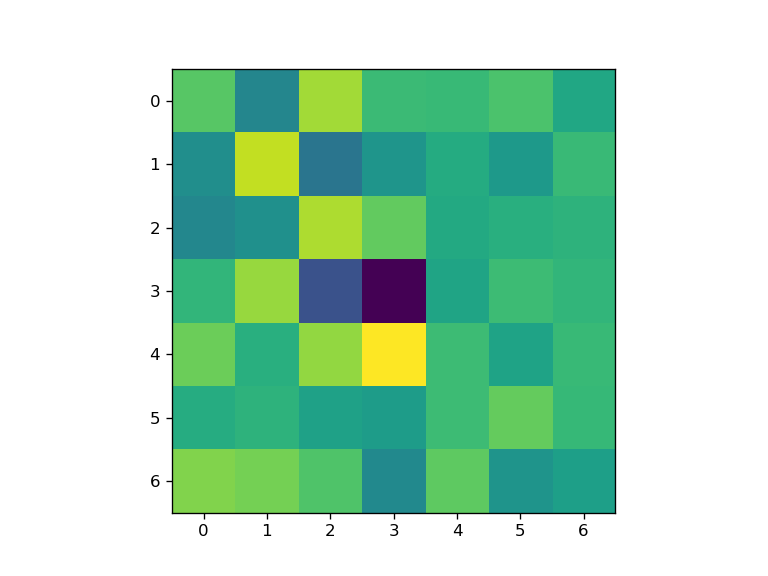

In [8]:
plt.figure()
plt.imshow(cutouts[712])

In [16]:
import numpy as np
from skimage.util.shape import view_as_windows
from scipy.optimize import minimize
from scipy.ndimage import shift

"""
PSF photometry class repurposed from Starkiller by Hugh Roxburgh
https://github.com/CheerfulUser/starkiller

"""

def downSample2d(arr,sf):
        """

        ----
        Inputs
        ----

        arr : array
            array to scale to 2d
        sf : float
            dimension of the scaled array
            
        ----
        Output
        ----

        array:
            rescaled array in 2d

        """
        
        isf2 = 1.0/(sf*sf)    # scalefactor
        windows = view_as_windows(arr, (sf,sf), step = sf)  # automatically scale down
        return windows.sum(3).sum(2)*isf2

def polynomial_surface(x, y, coeffs, order=2):
    """Evaluate an n-order polynomial surface."""
    z = np.zeros_like(x,dtype=float)
    ind = 0
    for i in range(order + 1):
        for j in range(order + 1 - i):
            z += coeffs[ind] * (x ** i) * (y ** j)
            ind += 1
    return z


class create_psf():
    def __init__(self,prf,size):
        
        self.prf = prf
        self.size = size
        self.source_x = 0         # offset of source from centre
        self.source_y = 0         # offset of source from centre

        # -- Finds centre of kernel -- #
        self.cent=self.size/2.-0.5

        self.psf = None

    def source(self,shiftx=0,shifty=0,ext_shift=[0,0]):

        """
        Creates the psf of a given source
        
        ----
        Inputs
        ----

        shiftx : float
            shift of source x-coordinate from centre of kernel
        shifty : float
            shift of source y-coordinate from centre of kernel
        ext_shift : array
            shift vector for psf array corresponding to offset from kernel centre to source centre
            
        ----
        Output
        ----
        
        psf: array
            psf for source at the given coordinates relative to the kernel centre

        """
        
        centx_s = self.cent + shiftx    # source centre
        centy_s = self.cent + shifty

        psf = self.prf.locate(centx_s-ext_shift[1],centy_s-ext_shift[0], (self.size,self.size))
        psf = shift(psf,ext_shift)
        self.psf = psf/np.nansum(psf)

    def minimize_position(self,coeff,image,ext_shift):
        """
        Applies an exponential function using psf residuals to optimise the psf fit.
        
        ----
        Inputs
        ----

        coeff : array
            offset of source from centre
        image : array
            actual flux array
        ext_shift : array
            shift vector for psf array corresponding to offset from kernel centre to source centre
            
        ----
        Output
        ----
        
        array:
            optimization model used for psf fitting
            
        """
        self.source_x = coeff[0]
        self.source_y = coeff[1]
        
        # -- generate psf -- #
        self.source(shiftx = self.source_x, shifty = self.source_y,ext_shift=ext_shift)

        # -- calculate residuals -- #
        diff = (image - self.psf * coeff[2])**2
        residual = np.nansum(diff)
        return np.exp(residual)
    
    def psf_position(self,image,limx=1,limy=1,ext_shift=[0,0]):
        """
        Finds the optimal psf fit
        
        ----
        Inputs
        ----

        image : array
            flux array to fit psf to
        limx : float
            bound to psf fit in (+ and -) x-direction
        limy : float
            bound to psf fit in (+ and -) Y-direction
        ext_shift : array
            shift vector for psf array corresponding to offset from kernel centre to source centre

        ----
        Outputs
        ----
        psf_fit: array
            Optimal psf fit to input image
            
        """

        normimage = image / np.nansum(image)    # normalise the image
        coeff = [self.source_x,self.source_y,1]
        lims = [[-limx,limx],[-limy,limy],[-1,1]]
        
        # -- Optimize -- #
        res = minimize(self.minimize_position, coeff, args=(normimage,ext_shift), method='Powell',bounds=lims)
        self.psf_fit = res

    def minimize_psf_flux(self,coeff,image,surface=True,order=2):

        """
        
        Calculates residuals to optimise psf flux
        
        ----
        Inputs
        ----

        coeff : array
            source mask for psf 
        image : array
            image flux array

        ----
        Outputs
        ----

        res: float
            flux residual of psf relative to image
        
        """
        if surface:
            x = np.arange(image.shape[1])
            y = np.arange(image.shape[0])
            yy,xx = np.meshgrid(y,x)
            plane_coeff = coeff[1:]
            s = polynomial_surface(xx,yy,plane_coeff,order)
        else:
            s = 0
        res = np.nansum((image - self.psf*coeff[0] - s)**2)
        return res

    def psf_flux(self,image,ext_shift=None,surface=True,poly_order=2):

        """
        
        Finds the optimal flux fit 

        ----
        Inputs
        ----

        image : array
            flux array to fit psf to
        ext_shift : array
            shift vector for psf array corresponding to offset from kernel centre to source centre

        ----
        Outputs
        ----
        
        flux : array
            optimal fit of psf flux to image
        image_residual : array
            residual of optimal psf flux fit 
            
        """
        
        if self.psf is None:
            self.source(shiftx=self.source_x,shifty=self.source_y)
        if ext_shift is not None:
            self.source(ext_shift=ext_shift)
        mask = np.zeros_like(self.psf)
        mask[self.psf > np.nanpercentile(self.psf,90)] = 1
        f0 = np.nansum(image*mask)
        print(f0)
        #bkg = np.nanmedian(image[~mask.astype(bool)])
        #image = image - bkg

        if surface:
            num_coeffs = (poly_order + 1) * (poly_order + 2) // 2
            initial = np.zeros(num_coeffs + 1)
            initial[0] = f0
        else:
            initial = f0
        
        res = minimize(self.minimize_psf_flux,initial,args=(image,surface,poly_order),method='BFGS')
        error = np.sqrt(np.diag(res['hess_inv']))
        self.res = res
        self.flux = res.x[0]
        self.eflux = error[0]
        
        if surface:
            x = np.arange(image.shape[1])
            y = np.arange(image.shape[0])
            yy,xx = np.meshgrid(y,x)
            plane_coeff = res.x[1:]
            s = polynomial_surface(xx,yy,plane_coeff,poly_order)
        else:
            s = image * 0
        self.surface = s
        self.image_residual = image - self.psf*self.flux - s


In [442]:
from scipy.optimize import leastsq

In [28]:
psf = create_psf(prf,size)

In [29]:
ind = 712
image = cutouts[ind]
#psf.psf_position(image)
psf.psf_flux(image,poly_order=3,surface=True)

-8.444233287541092


In [48]:
for i in range(len(tess.lc[0])):
    psf.psf_position(cutouts[i],ext_shift=tess.shift[i])

[0. 0. 1.]
[-0.23606798  0.          1.        ]
[0.23606798 0.         1.        ]
[0.52786405 0.         1.        ]
[0.70820393 0.         1.        ]
[0.64066859 0.         1.        ]
[0.62713852 0.         1.        ]
[0.63498008 0.         1.        ]
[0.63453006 0.         1.        ]
[0.6345634 0.        1.       ]
[0.63449671 0.         1.        ]
[ 0.63453006 -0.23606798  1.        ]
[0.63453006 0.23606798 1.        ]
[0.63453006 0.52786405 1.        ]
[0.63453006 0.2827961  1.        ]
[0.63453006 0.33568766 1.        ]
[0.63453006 0.29115597 1.        ]
[0.63453006 0.29112264 1.        ]
[0.63453006 0.29118931 1.        ]
[ 0.63453006  0.29115597 -0.23606798]
[0.63453006 0.29115597 0.23606798]
[0.63453006 0.29115597 0.52786405]
[0.63453006 0.29115597 0.37691701]
[0.63453006 0.29115597 0.37679674]
[0.63453006 0.29115597 0.37683008]
[0.63453006 0.29115597 0.3767634 ]
[1.         0.45885293 0.01785069]
[0.38196601 0.17526622 0.62485234]
[0.61803399 0.2835867  0.39299834]
[0.

[0.99762752 0.20705447 1.        ]
[0.99853373 0.20705447 1.        ]
[0.99909379 0.20705447 1.        ]
[0.99943993 0.20705447 1.        ]
[0.99965386 0.20705447 1.        ]
[0.99978607 0.20705447 1.        ]
[0.99986779 0.20705447 1.        ]
[0.99991829 0.20705447 1.        ]
[0.99995164 0.20705447 1.        ]
[ 0.99995164 -0.23606798  1.        ]
[0.99995164 0.23606798 1.        ]
[ 0.99995164 -0.52786405  1.        ]
[ 0.99995164 -0.51033815  1.        ]
[ 0.99995164 -0.53195607  1.        ]
[ 0.99995164 -0.52697943  1.        ]
[ 0.99995164 -0.52701278  1.        ]
[ 0.99995164 -0.52694609  1.        ]
[ 0.99995164 -0.52697943 -0.23606798]
[ 0.99995164 -0.52697943  0.23606798]
[ 0.99995164 -0.52697943  0.52786405]
[ 0.99995164 -0.52697943  0.43637267]
[ 0.99995164 -0.52697943  0.43859251]
[ 0.99995164 -0.52697943  0.4385161 ]
[ 0.99995164 -0.52697943  0.43854944]
[ 0.99995164 -0.52697943  0.43848275]
[ 1.         -0.52700369  0.43849754]
[-0.23606798 -0.52697943  0.4385161 ]
[ 0.

[0.1452679  0.90665701 0.42028379]
[0.14519743 0.90665701 0.42028379]
[0.14515388 0.90665701 0.42028379]
[0.14512054 0.90665701 0.42028379]
[ 0.14512054 -0.23606798  0.42028379]
[0.14512054 0.23606798 0.42028379]
[0.14512054 0.52786405 0.42028379]
[0.14512054 0.70820393 0.42028379]
[0.14512054 0.81966011 0.42028379]
[0.14512054 0.95678247 0.42028379]
[0.14512054 0.92926712 0.42028379]
[0.14512054 0.94667903 0.42028379]
[0.14512054 0.94852217 0.42028379]
[0.14512054 0.94855551 0.42028379]
[0.14512054 0.94848884 0.42028379]
[ 0.14512054  0.94852217 -0.23606798]
[0.14512054 0.94852217 0.23606798]
[0.14512054 0.94852217 0.52786405]
[0.14512054 0.94852217 0.4185958 ]
[0.14512054 0.94852217 0.41976601]
[0.14512054 0.94852217 0.41971676]
[0.14512054 0.94852217 0.41968343]
[0.14512054 0.94852217 1.        ]
[-0.23606798  0.94852217  1.        ]
[0.23606798 0.94852217 1.        ]
[0.52786405 0.94852217 1.        ]
[0.17024494 0.94852217 1.        ]
[0.01504721 0.94852217 1.        ]
[0.11898323

[0.05070308 0.89259364 0.25089695]
[0.05070308 0.89189318 0.25089695]
[0.05070308 0.89216073 0.25089695]
[0.05070308 0.89196827 0.25089695]
[0.05070308 0.89200232 0.25089695]
[0.05070308 0.89206283 0.25089695]
[ 0.0655667   0.8586823  -0.23606798]
[0.0511557  0.89098767 0.23606798]
[0.04224922 0.91095348 0.52786405]
[0.05073045 0.89194096 0.2500002 ]
[0.05070758 0.89199223 0.2507495 ]
[0.05070306 0.89200236 0.25089746]
[0.05070307 0.89200235 0.25089736]
[0.05070307 0.89200235 0.25089738]
[0.05070307 0.89200235 0.2508974 ]
[0.05070307 0.89200235 1.        ]
[-0.23606798  0.89200235  1.        ]
[0.23606798 0.89200235 1.        ]
[-0.52786405  0.89200235  1.        ]
[-0.14665924  0.89200235  1.        ]
[-0.23863168  0.89200235  1.        ]
[-0.21626569  0.89200235  1.        ]
[-0.18967839  0.89200235  1.        ]
[-0.22407941  0.89200235  1.        ]
[-0.22411275  0.89200235  1.        ]
[-0.22404607  0.89200235  1.        ]
[-0.22407941 -0.23606798  1.        ]
[-0.22407941  0.236067

[-0.70396796  0.43659038  1.        ]
[-0.70396796  0.43665704  1.        ]
[-0.70396796  0.43662371 -0.23606798]
[-0.70396796  0.43662371  0.23606798]
[-0.70396796  0.43662371  0.52786405]
[-0.70396796  0.43662371  0.32227513]
[-0.70396796  0.43662371  0.32131695]
[-0.70396796  0.43662371  0.3213863 ]
[-0.70396796  0.43662371  0.32135296]
[-0.70396796  0.43662371  0.32141965]
[-0.62136071  0.43550779 -0.3572274 ]
[-0.69358221  0.43648341  0.23606798]
[-0.63610937  0.43570703 -0.23606798]
[-0.72910238  0.43696325  0.52786405]
[-0.70410089  0.43662551  0.32247831]
[-0.70408043  0.43662523  0.3223102 ]
[-0.70410944  0.43662562  0.32254852]
[-0.70410668  0.43662558  0.3225259 ]
[-0.70411219  0.43662566  0.32257114]
[-0.23606798  0.43662562  0.32254852]
[0.23606798 0.43662562 0.32254852]
[-0.52786405  0.43662562  0.32254852]
[-0.70820393  0.43662562  0.32254852]
[-0.86226595  0.43662562  0.32254852]
[-0.78454677  0.43662562  0.32254852]
[-0.78449271  0.43662562  0.32254852]
[-0.81423286  0

[-0.80726966  0.35259607  0.23606798]
[-0.80726966  0.35259607  0.52786405]
[-0.80726966  0.35259607  0.2358535 ]
[-0.80726966  0.35259607  0.23504119]
[-0.80726966  0.35259607  0.23500785]
[-0.80726966  0.35259607  0.23507452]
[-1.          0.27775799  0.2366226 ]
[0.14953599 0.7241281  0.2271903 ]
[-0.28954769  0.55362989  0.23079312]
[-0.56091632  0.4482562   0.23301978]
[-0.72863136  0.38313168  0.23439593]
[-0.87333846  0.32694125  0.2355833 ]
[-0.80076287  0.35512269  0.2349878 ]
[-0.80075483  0.35512581  0.23498773]
[-0.80752205  0.35249807  0.23504326]
[-0.83266168  0.34273623  0.23524954]
[-0.80644476  0.35291638  0.23503442]
[-0.80643724  0.3529193   0.23503436]
[-0.80645228  0.35291346  0.23503448]
[-0.80644476  0.35291638 -0.23606798]
[-0.80644476  0.35291638  0.23606798]
[-0.80644476  0.35291638  0.52786405]
[-0.80644476  0.35291638  0.23587397]
[-0.80644476  0.35291638  0.23506159]
[-0.80644476  0.35291638  0.23502826]
[-0.80644476  0.35291638  0.23509493]
[-0.80644476 -0

[-0.84957082  0.59757634  1.        ]
[-0.82578949  0.59757634  1.        ]
[-0.80552365  0.59757634  1.        ]
[-0.80561893  0.59757634  1.        ]
[-0.8055856   0.59757634  1.        ]
[-0.8055856  -0.23606798  1.        ]
[-0.8055856   0.23606798  1.        ]
[-0.8055856   0.52786405  1.        ]
[-0.8055856   0.43336716  1.        ]
[-0.8055856   0.39437934  1.        ]
[-0.8055856   0.39595599  1.        ]
[-0.8055856  0.4058283  1.       ]
[-0.8055856   0.40586164  1.        ]
[-0.8055856   0.40579497  1.        ]
[-0.8055856   0.4058283  -0.23606798]
[-0.8055856   0.4058283   0.23606798]
[-0.8055856   0.4058283   0.52786405]
[-0.8055856   0.4058283   0.26462812]
[-0.8055856   0.4058283   0.26360326]
[-0.8055856   0.4058283   0.26365828]
[-0.8055856   0.4058283   0.26369163]
[-0.86761451  0.21408026 -0.47268343]
[-0.23606798  0.4058283   0.26365828]
[0.23606798 0.4058283  0.26365828]
[-0.52786405  0.4058283   0.26365828]
[-0.70820393  0.4058283   0.26365828]
[-0.81966011  0.40

[0.98995    0.76068322 1.        ]
[0.99378876 0.76068322 1.        ]
[0.99616124 0.76068322 1.        ]
[0.99762752 0.76068322 1.        ]
[0.99853373 0.76068322 1.        ]
[0.99909379 0.76068322 1.        ]
[0.99943993 0.76068322 1.        ]
[0.99965386 0.76068322 1.        ]
[0.99978607 0.76068322 1.        ]
[0.99986779 0.76068322 1.        ]
[0.99991829 0.76068322 1.        ]
[0.99995165 0.76068322 1.        ]
[ 0.99995165 -0.23606798  1.        ]
[0.99995165 0.23606798 1.        ]
[0.99995165 0.52786405 1.        ]
[0.99995165 0.70820393 1.        ]
[0.99995165 0.6446898  1.        ]
[0.99995165 0.68438116 1.        ]
[0.99995165 0.81966011 1.        ]
[0.99995165 0.6869946  1.        ]
[0.99995165 0.75077641 1.        ]
[0.99995165 0.77708764 1.        ]
[0.99995165 0.73451517 1.        ]
[0.99995165 0.73420693 1.        ]
[0.99995165 0.73424026 1.        ]
[0.99995165 0.7341736  1.        ]
[ 0.99995165  0.73420693 -0.23606798]
[0.99995165 0.73420693 0.23606798]
[0.99995165 0.

[ 0.35181032 -0.88789619  0.29448064]
[ 0.39764183 -0.88789619  0.29448064]
[ 0.39743815 -0.88789619  0.29448064]
[ 0.39747148 -0.88789619  0.29448064]
[ 0.39740481 -0.88789619  0.29448064]
[ 0.39743815 -0.88789619 -0.23606798]
[ 0.39743815 -0.88789619  0.23606798]
[ 0.39743815 -0.88789619  0.52786405]
[ 0.39743815 -0.88789619  0.34874566]
[ 0.39743815 -0.88789619  0.3480617 ]
[ 0.39743815 -0.88789619  0.34810773]
[ 0.39743815 -0.88789619  0.34814106]
[-0.4251464  -0.03046734  0.34858929]
[-0.06986734 -0.40079586  0.3483813 ]
[ 0.1497072  -0.62967148  0.34825276]
[ 0.28541173 -0.77112439  0.34817331]
[ 0.36928174 -0.85854709  0.34812421]
[ 0.43197515 -0.92389617  0.34808751]
[ 0.39358818 -0.88388314  0.34810998]
[ 0.39189196 -0.88211508  0.34811098]
[ 0.40203114 -0.89268374  0.34810504]
[ 0.3968131  -0.88724467  0.34810809]
[ 0.39642184 -0.88683684  0.34810832]
[ 0.39646769 -0.88688463  0.3481083 ]
[ 0.396376   -0.88678906  0.34810835]
[ 0.50469277 -1.          0.35228123]
[-0.23606798

[0.32449394 0.99762752 0.25172411]
[0.32463682 0.99853373 0.25138466]
[0.32472512 0.99909379 0.25117487]
[0.32477969 0.99943993 0.25104521]
[0.32481342 0.99965386 0.25096508]
[0.32483427 0.99978607 0.25091556]
[0.32484715 0.99986779 0.25088495]
[-0.23606798  0.99986779  0.25088495]
[0.23606798 0.99986779 0.25088495]
[0.52786405 0.99986779 0.25088495]
[0.36931799 0.99986779 0.25088495]
[0.36994267 0.99986779 0.25088495]
[0.34829185 0.99986779 0.25088495]
[0.30542614 0.99986779 0.25088495]
[0.3319186  0.99986779 0.25088495]
[0.35065877 0.99986779 0.25088495]
[0.34203782 0.99986779 0.25088495]
[0.33817263 0.99986779 0.25088495]
[0.34442665 0.99986779 0.25088495]
[0.34056145 0.99986779 0.25088495]
[0.34238535 0.99986779 0.25088495]
[0.34181386 0.99986779 0.25088495]
[0.34133548 0.99986779 0.25088495]
[0.34103983 0.99986779 0.25088495]
[0.34151821 0.99986779 0.25088495]
[0.34122255 0.99986779 0.25088495]
[0.34140304 0.99986779 0.25088495]
[0.34130215 0.99986779 0.25088495]
[0.34136882 0.999

[ 0.98439311 -0.99995159  0.36721509]
[ 0.99035441 -0.9999516   0.3670817 ]
[ 0.9940387  -0.99995161  0.36699927]
[ 0.99631571 -0.99995161  0.36694832]
[ 0.99772299 -0.99995162  0.36691683]
[ 0.99859273 -0.99995162  0.36689737]
[ 0.99913026 -0.99995162  0.36688534]
[ 0.99946247 -0.99995162  0.36687791]
[ 0.99966779 -0.99995162  0.36687331]
[ 0.99979468 -0.99995162  0.36687047]
[ 0.99987311 -0.99995162  0.36686872]
[ 0.99992158 -0.99995162  0.36686764]
[ 0.99995153 -0.99995162  0.36686697]
[ 0.99997004 -0.99995162  0.36686655]
[ 0.99998149 -0.99995162  0.36686629]
[ 0.99998856 -0.99995162  0.36686614]
[ 0.99999293 -0.99995162  0.36686604]
[ 0.99999563 -0.99995162  0.36686598]
[ 0.9999973  -0.99995162  0.36686594]
[ 0.99999833 -0.99995162  0.36686592]
[ 0.99999897 -0.99995162  0.3668659 ]
[ 0.99999936 -0.99995162  0.36686589]
[ 0.99999961 -0.99995162  0.36686589]
[ 0.99999977 -0.99995162  0.36686589]
[ 0.99999977 -0.99995162  1.        ]
[-0.23606798 -0.99995162  1.        ]
[ 0.23606798

[0.44510362 0.95519098 0.39102862]
[0.44510362 0.95519098 0.39128318]
[0.44510362 0.95519098 0.39124985]
[0.44510362 0.95519098 0.39131651]
[ 0.75428341 -0.23606798  0.39596607]
[0.63174507 0.23606798 0.39411008]
[0.55601221 0.52786405 0.39296302]
[0.50920673 0.70820393 0.3922541 ]
[0.48027935 0.81966011 0.39181596]
[0.46240125 0.88854382 0.39154517]
[0.43955543 0.97656796 0.39119915]
[0.4472642  0.94686637 0.3913159 ]
[0.44508209 0.95527393 0.39128285]
[0.44458151 0.95720268 0.39127527]
[0.44534081 0.95427709 0.39128677]
[0.44504369 0.95542191 0.39128227]
[0.44514105 0.95504677 0.39128375]
[0.44512486 0.95510917 0.3912835 ]
[0.44511493 0.95514743 0.39128335]
[0.44511886 0.95513226 0.39128341]
[0.44511965 0.95512922 0.39128342]
[0.44512164 0.95512157 0.39128345]
[0.44511999 0.95512792 0.39128343]
[0.44512039 0.95512638 0.39128343]
[0.44511993 0.95512815 0.39128343]
[0.44511986 0.95512841 0.39128343]
[0.44511991 0.95512822 0.39128343]
[0.4451199  0.95512825 0.39128343]
[0.44511991 0.955

[-0.64120887  0.99995163  0.11090782]
[-0.64120887  0.99995163  0.1115243 ]
[-0.64120887  0.99995163  0.11119468]
[-0.64120887  0.99995163  0.11116133]
[-0.64120887  0.99995163  0.11122803]
[-0.6412948   1.          0.11109856]
[-0.15016936  0.72352013  0.66046986]
[-0.33776259  0.82912605  0.4506287 ]
[-0.45370157  0.89439409  0.32093973]
[-0.59910092  0.97624689  0.15829649]
[-0.63207633  0.99481045  0.12141031]
[-0.61948084  0.9877198   0.13549958]
[-0.62726528  0.99210206  0.12679193]
[-0.63559747  0.99679268  0.11747157]
[-0.63777366  0.99801777  0.1150373 ]
[-0.63911861  0.99877491  0.11353284]
[-0.63994984  0.99924285  0.11260303]
[-0.64046357  0.99953206  0.11202837]
[-0.64078107  0.9997108   0.11167322]
[-0.6409773   0.99982126  0.11145372]
[-0.64109857  0.99988953  0.11131806]
[-0.64117353  0.99993173  0.11123422]
[-0.64121985  0.99995781  0.1111824 ]
[-0.64124848  0.99997392  0.11115038]
[-0.23606798  0.99997392  0.11115038]
[0.23606798 0.99997392 0.11115038]
[0.52786405 0.9

[ 0.61140045 -0.78191134  0.25678719]
[ 0.61140045 -0.78158626  0.25678719]
[ 0.61140045 -0.78211225  0.25678719]
[ 0.61140045 -0.78178717  0.25678719]
[ 0.61140045 -0.78182678  0.25678719]
[ 0.61140045 -0.78186011  0.25678719]
[0.35999477 0.23606798 0.14385613]
[ 0.4766057  -0.23606798  0.19623759]
[ 0.54867523 -0.52786405  0.22861112]
[ 0.59321664 -0.70820393  0.24861905]
[ 0.64325293 -0.91079154  0.27109528]
[ 0.61255912 -0.78651803  0.25730767]
[ 0.6135575  -0.79056029  0.25775614]
[ 0.61104928 -0.78040495  0.25662945]
[ 0.60423781 -0.75282662  0.25356975]
[ 0.61173502 -0.78318139  0.25693748]
[ 0.61177783 -0.78335475  0.25695671]
[ 0.61159362 -0.78260892  0.25687397]
[ 0.6113857  -0.78176708  0.25678057]
[ 0.6112572  -0.78124679  0.25672284]
[ 0.61146512 -0.78208863  0.25681624]
[ 0.61130936 -0.78145801  0.25674628]
[ 0.61141604 -0.7818899   0.25679419]
[ 0.61140662 -0.78185177  0.25678996]
[ 0.6114024  -0.78183471  0.25678807]
[ 0.61139602 -0.78180887  0.2567852 ]
[ 0.61139208 -0

[0.47511776 0.56236205 0.50980406]
[0.39996132 0.72952487 0.3940845 ]
[0.35351209 0.83283718 0.32256587]
[0.32480488 0.89668769 0.27836493]
[0.30706286 0.93614948 0.25104725]
[0.29609768 0.96053821 0.23416399]
[0.28932083 0.97561127 0.22372956]
[0.2851325  0.98492694 0.21728073]
[0.28254398 0.99068434 0.21329514]
[0.28094418 0.9942426  0.2108319 ]
[0.27995545 0.99644173 0.20930954]
[0.27934438 0.99780087 0.20836867]
[0.27896672 0.99864086 0.20778718]
[0.27873331 0.99916001 0.2074278 ]
[0.27858906 0.99948086 0.20720569]
[0.2784999  0.99967915 0.20706842]
[0.2784448  0.9998017  0.20698358]
[0.27841075 0.99987745 0.20693115]
[0.2783897  0.99992426 0.20689874]
[0.2783767  0.99995319 0.20687871]
[0.27836866 0.99997107 0.20686633]
[0.27836369 0.99998212 0.20685868]
[0.27836062 0.99998895 0.20685396]
[0.27835872 0.99999317 0.20685104]
[0.27835755 0.99999578 0.20684923]
[0.27835682 0.99999739 0.20684811]
[0.27835638 0.99999839 0.20684742]
[0.2783561 0.999999  0.206847 ]
[0.27835593 0.99999938 

[ 0.23606798 -0.1507251   0.14308211]
[ 0.52786405 -0.03185542  0.14439968]
[0.70820393 0.04161009 0.14521398]
[0.81966011 0.08701427 0.14571725]
[0.88854382 0.11507559 0.14602828]
[0.93111629 0.13241845 0.14622051]
[0.95742753 0.14313692 0.14633932]
[0.97368877 0.1497613  0.14641274]
[0.98373876 0.15385539 0.14645812]
[0.98995    0.15638568 0.14648617]
[0.99378876 0.15794949 0.1465035 ]
[0.99616124 0.15891597 0.14651421]
[0.99762752 0.15951329 0.14652083]
[0.99853373 0.15988245 0.14652493]
[0.99909379 0.16011061 0.14652745]
[0.99943993 0.16025162 0.14652902]
[0.99965386 0.16033877 0.14652998]
[0.99978607 0.16039263 0.14653058]
[0.99986779 0.16042591 0.14653095]
[0.99992196 0.16044798 0.14653119]
[ 0.20361055 -0.22693821 -0.56203753]
[ 0.50780425 -0.07895535 -0.29136183]
[ 0.6958063   0.01250309 -0.12407506]
[ 0.81199795  0.06902751 -0.02068614]
[0.88380834 0.10396152 0.04321172]
[0.92818961 0.12555193 0.08270277]
[0.95561874 0.13889554 0.10710959]
[0.97257087 0.14714234 0.12219382]
[0

[-0.74376511  0.13049103  0.22203117]
[-0.74376511  0.13045769  0.22203117]
[-0.74376511  0.13052436  0.22203117]
[-0.23606798  0.3513309   0.21448668]
[0.23606798 0.55670225 0.20747063]
[-0.52786405  0.22440443  0.21882284]
[-0.70820393  0.14595955  0.22150273]
[-0.74562969  0.12967997  0.22205888]
[-0.73832559  0.13285713  0.22195034]
[-0.73634787  0.13371741  0.22192095]
[-0.73631203  0.13373299  0.22192042]
[-0.73631414  0.13373208  0.22192045]
[-0.73631488  0.13373176  0.22192046]
[-0.7363134   0.1337324   0.22192044]
[-0.7363134  0.1337324  1.       ]
[-0.23606798  0.1337324   1.        ]
[0.23606798 0.1337324  1.        ]
[-0.52786405  0.1337324   1.        ]
[-0.70820393  0.1337324   1.        ]
[-0.81966011  0.1337324   1.        ]
[-0.88854382  0.1337324   1.        ]
[-0.93111629  0.1337324   1.        ]
[-0.95742753  0.1337324   1.        ]
[-0.97368877  0.1337324   1.        ]
[-0.98373876  0.1337324   1.        ]
[-0.98995    0.1337324  1.       ]
[-0.99378876  0.1337324 

[-0.23606798 -0.22853257  1.        ]
[ 0.23606798 -0.22853257  1.        ]
[-0.52786405 -0.22853257  1.        ]
[-0.70820393 -0.22853257  1.        ]
[-0.90341866 -0.22853257  1.        ]
[-0.82885327 -0.22853257  1.        ]
[-0.94030945 -0.22853257  1.        ]
[-0.96310921 -0.22853257  1.        ]
[-0.97720024 -0.22853257  1.        ]
[-0.98590897 -0.22853257  1.        ]
[-0.99129127 -0.22853257  1.        ]
[-0.99461771 -0.22853257  1.        ]
[-0.99667356 -0.22853257  1.        ]
[-0.99794415 -0.22853257  1.        ]
[-0.99872941 -0.22853257  1.        ]
[-0.99921473 -0.22853257  1.        ]
[-0.99951468 -0.22853257  1.        ]
[-0.99970006 -0.22853257  1.        ]
[-0.99981462 -0.22853257  1.        ]
[-0.99988543 -0.22853257  1.        ]
[-0.99992919 -0.22853257  1.        ]
[-0.99996253 -0.22853257  1.        ]
[-0.99996253 -0.23606798  1.        ]
[-0.99996253  0.23606798  1.        ]
[-0.99996253 -0.52786405  1.        ]
[-0.99996253 -0.04142329  1.        ]
[-0.99996253

[0.27597087 0.99691795 0.55178456]
[0.31696741 0.99691821 0.59838724]
[0.27455955 0.99691795 0.55018024]
[0.27544413 0.99691795 0.55118579]
[0.27544853 0.99691795 0.55119079]
[0.27544866 0.99691795 0.55119094]
[0.27544865 0.99691795 0.55119093]
[0.27544865 0.99691795 0.55119092]
[0.2754486  0.99691795 0.55119087]
[0.27544863 0.99691795 0.5511909 ]
[0.27544864 0.99691795 0.55119092]
[0.41643287 0.9938359  0.72001858]
[0.15874695 0.5665741  0.82781347]
[0.20364228 0.73212806 0.72139634]
[0.23138912 0.83444604 0.65562693]
[0.24853761 0.89768202 0.6149792 ]
[0.25913596 0.93676401 0.58985753]
[0.2656861  0.96091801 0.57433148]
[0.26973431 0.975846   0.56473585]
[0.27223624 0.98507201 0.55880543]
[0.27378251 0.99077399 0.55514022]
[0.27473817 0.99429801 0.552875  ]
[0.27532879 0.99647598 0.55147502]
[0.27569382 0.99782204 0.55060978]
[0.27591942 0.99865394 0.55007504]
[0.27605885 0.99916809 0.54974455]
[0.27614502 0.99948585 0.54954029]
[0.27619827 0.99968224 0.54941406]
[0.27623119 0.999803

[ 0.99995162 -0.12030272  0.23351197]
[ 0.99995162 -0.11821609  0.23351197]
[ 0.99995162 -0.1195057   0.23351197]
[ 0.99995162 -0.11873742  0.23351197]
[ 0.99995162 -0.11890229  0.23351197]
[ 0.99995162 -0.11886895  0.23351197]
[ 0.99995162 -0.11893562  0.23351197]
[ 0.99995162 -0.11896895  0.23351197]
[ 0.83038737 -0.43641331  0.707176  ]
[ 0.89517363 -0.31511302  0.52620082]
[ 0.93521374 -0.24014532  0.41435201]
[ 0.95995989 -0.19381274  0.34522564]
[ 0.97525385 -0.16517762  0.30250319]
[ 0.98470604 -0.14748015  0.27609927]
[ 0.99054781 -0.13654251  0.25978075]
[ 0.99415823 -0.12978268  0.24969535]
[ 0.99638959 -0.12560487  0.24346223]
[ 0.99776864 -0.12302285  0.23960995]
[ 0.99862094 -0.12142707  0.2372291 ]
[ 0.9991477  -0.12044082  0.23575766]
[ 0.99947325 -0.11983129  0.23484826]
[ 0.99967445 -0.11945457  0.23428622]
[ 0.9997988  -0.11922175  0.23393886]
[ 0.99987565 -0.11907786  0.23372418]
[ 0.99992315 -0.11898893  0.2335915 ]
[ 0.9999525  -0.11893397  0.2335095 ]
[ 0.99997065

[-0.49410203  0.93111629  0.72484258]
[-0.49577075  0.95742753  0.72109359]
[-0.49680207  0.97368877  0.71877659]
[-0.49743946  0.98373876  0.7173446 ]
[-0.49783339  0.98995     0.71645959]
[-0.49807685  0.99378876  0.71591262]
[-0.49822732  0.99616124  0.71557457]
[-0.49832031  0.99762752  0.71536565]
[-0.49837778  0.99853373  0.71523652]
[-0.49841331  0.99909379  0.71515672]
[-0.49843526  0.99943993  0.7151074 ]
[-0.49844883  0.99965386  0.71507692]
[-0.49845721  0.99978607  0.71505808]
[-0.49846239  0.99986779  0.71504644]
[-0.23606798  0.99986779  0.71504644]
[0.23606798 0.99986779 0.71504644]
[-0.52786405  0.99986779  0.71504644]
[-0.68715978  0.99986779  0.71504644]
[-0.76763215  0.99986779  0.71504644]
[-0.75640208  0.99986779  0.71504644]
[-0.74950283  0.99986779  0.71504644]
[-0.74953617  0.99986779  0.71504644]
[-0.7494695   0.99986779  0.71504644]
[-0.74950283  0.99986779 -0.23606798]
[-0.74950283  0.99986779  0.23606798]
[-0.74950283  0.99986779  0.52786405]
[-0.74950283  0

[ 0.70820393 -0.12109398  1.        ]
[ 0.81490245 -0.12109398  1.        ]
[ 0.71415192 -0.12109398  1.        ]
[ 0.72054463 -0.12109398  1.        ]
[ 0.71709025 -0.12109398  1.        ]
[ 0.71712361 -0.12109398  1.        ]
[ 0.7170569  -0.12109398  1.        ]
[ 0.71709025 -0.23606798  1.        ]
[0.71709025 0.23606798 1.        ]
[ 0.71709025 -0.52786405  1.        ]
[ 0.71709025 -0.70820393  1.        ]
[ 0.71709025 -0.63400958  1.        ]
[ 0.71709025 -0.63159086  1.        ]
[ 0.71709025 -0.59197074  1.        ]
[ 0.71709025 -0.61628705  1.        ]
[ 0.71709025 -0.61625371  1.        ]
[ 0.71709025 -0.61632039  1.        ]
[ 0.71709025 -0.61628705 -0.23606798]
[ 0.71709025 -0.61628705  0.23606798]
[ 0.71709025 -0.61628705  0.52786405]
[ 0.71709025 -0.61628705  0.2283768 ]
[ 0.71709025 -0.61628705  0.22761726]
[ 0.71709025 -0.61628705  0.22758392]
[ 0.71709025 -0.61628705  0.22755057]
[ 1.         -0.71210642  0.07812217]
[-0.07845888 -0.34684064  0.647874  ]
[ 0.33347576 -0

[-0.34020488 -0.9999502   0.94422045]
[-0.34020488 -0.9999502   0.96552634]
[-0.34020488 -0.9999502   0.97869411]
[-0.34020488 -0.9999502   0.98683224]
[-0.34020488 -0.9999502   0.99186187]
[-0.34020488 -0.9999502   0.99497036]
[-0.34020488 -0.9999502   0.99689151]
[-0.34020488 -0.9999502   0.99807885]
[-0.34020488 -0.9999502   0.99881266]
[-0.34020488 -0.9999502   0.99926619]
[-0.34020488 -0.9999502   0.99954648]
[-0.34020488 -0.9999502   0.99971971]
[-0.34020488 -0.9999502   0.99982677]
[-0.34020488 -0.9999502   0.99989294]
[-0.34020488 -0.9999502   0.99993383]
[-0.3402393  -1.          0.99993383]
[-0.23606798 -0.9999502   0.99993383]
[ 0.23606798 -0.9999502   0.99993383]
[-0.52786405 -0.9999502   0.99993383]
[-0.53613117 -0.9999502   0.99993383]
[-0.61707568 -0.9999502   0.99993383]
[-0.56704922 -0.9999502   0.99993383]
[-0.5744309  -0.9999502   0.99993383]
[-0.56254524 -0.9999502   0.99993383]
[-0.55245597 -0.9999502   0.99993383]
[-0.55869148 -0.9999502   0.99993383]
[-0.5632212 

[0.27095941 0.57896989 1.        ]
[0.27095941 0.61529947 1.        ]
[0.27095941 0.61526614 1.        ]
[0.27095941 0.61533281 1.        ]
[ 0.27095941  0.61529947 -0.23606798]
[0.27095941 0.61529947 0.23606798]
[0.27095941 0.61529947 0.52786405]
[0.27095941 0.61529947 0.1249425 ]
[0.27095941 0.61529947 0.1254713 ]
[0.27095941 0.61529947 0.12512684]
[0.27095941 0.61529947 0.12509349]
[0.27095941 0.61529947 0.12516019]
[ 1.          0.80407613 -0.37671298]
[-0.23606798  0.48401058  0.47414243]
[0.23606798 0.60626474 0.14914458]
[ 0.52786405  0.68182197 -0.05171513]
[0.29597265 0.62177637 0.10790881]
[0.27626796 0.61667406 0.12147266]
[0.27598162 0.61659992 0.12166977]
[0.27592385 0.61658496 0.12170954]
[0.27588148 0.61657399 0.1217387 ]
[-0.23606798  0.61658496  0.12170954]
[0.23606798 0.61658496 0.12170954]
[0.52786405 0.61658496 0.12170954]
[0.28778554 0.61658496 0.12170954]
[0.27362379 0.61658496 0.12170954]
[0.301211   0.61658496 0.12170954]
[0.30109831 0.61658496 0.12170954]
[0.30

[0.12163301 0.21427875 1.        ]
[0.29498988 0.21427875 1.        ]
[0.22357899 0.21427875 1.        ]
[0.24654582 0.21427875 1.        ]
[0.24660048 0.21427875 1.        ]
[0.24663382 0.21427875 1.        ]
[ 0.24660048 -0.23606798  1.        ]
[0.24660048 0.23606798 1.        ]
[0.24660048 0.52786405 1.        ]
[0.24660048 0.36023586 1.        ]
[0.24660048 0.36991221 1.        ]
[0.24660048 0.38266794 1.        ]
[0.24660048 0.37478447 1.        ]
[0.24660048 0.37542462 1.        ]
[0.24660048 0.37545795 1.        ]
[0.24660048 0.37539128 1.        ]
[ 0.24660048  0.37542462 -0.23606798]
[0.24660048 0.37542462 0.23606798]
[0.24660048 0.37542462 0.52786405]
[0.24660048 0.37542462 0.36509005]
[0.24660048 0.37542462 0.36469855]
[0.24660048 0.37542462 0.3647319 ]
[0.24660048 0.37542462 0.36476524]
[-0.50679904  0.53657049 -0.2705362 ]
[-0.23606798  0.37542462  0.3647319 ]
[0.23606798 0.37542462 0.3647319 ]
[0.52786405 0.37542462 0.3647319 ]
[0.18802061 0.37542462 0.3647319 ]
[0.20960

[-0.9999452  -0.99995164  0.99978607]
[-0.9999452  -0.99995164  0.99986779]
[-0.9999452  -0.99995164  0.99991829]
[-0.9999452  -0.99995164  0.99995162]
[-0.9999452  -1.          0.99995162]
[-0.99997907 -0.24335655  0.99998152]
[-0.99996613 -0.53236863  0.9999701 ]
[-0.99995814 -0.71098792  0.99996304]
[-0.9999532  -0.82138071  0.99995868]
[-0.99995014 -0.88960721  0.99995598]
[-0.99994826 -0.9317735   0.99995431]
[-0.99994709 -0.95783371  0.99995329]
[-0.99994637 -0.9739398   0.99995265]
[-0.99994592 -0.98389391  0.99995226]
[-0.99994565 -0.99004589  0.99995201]
[-0.99994548 -0.99384802  0.99995186]
[-0.99994537 -0.99619787  0.99995177]
[-0.99994531 -0.99765015  0.99995171]
[-0.99994527 -0.99854771  0.99995168]
[-0.99994524 -0.99910244  0.99995165]
[-0.99994523 -0.99944528  0.99995164]
[-0.99994522 -0.99965716  0.99995163]
[-0.99994521 -0.99978811  0.99995163]
[-0.99994521 -0.99986905  0.99995162]
[-0.99994521 -0.99991907  0.99995162]
[-0.23606798 -0.99991907  0.99995162]
[ 0.23606798

[-0.89462549 -0.99995648  0.88854382]
[-0.89462549 -0.99995648  0.93111629]
[-0.89462549 -0.99995648  0.95742753]
[-0.89462549 -0.99995648  0.97368877]
[-0.89462549 -0.99995648  0.98373876]
[-0.89462549 -0.99995648  0.98995   ]
[-0.89462549 -0.99995648  0.99378876]
[-0.89462549 -0.99995648  0.99616124]
[-0.89462549 -0.99995648  0.99762752]
[-0.89462549 -0.99995648  0.99853373]
[-0.89462549 -0.99995648  0.99909379]
[-0.89462549 -0.99995648  0.99943993]
[-0.89462549 -0.99995648  0.99965386]
[-0.89462549 -0.99995648  0.99978607]
[-0.89462549 -0.99995648  0.99986779]
[-0.89462549 -0.99995648  0.99991829]
[-0.89462549 -0.99995648  0.99995162]
[-0.09575872 -0.59314653  0.99998152]
[-0.40093131 -0.74855073  0.9999701 ]
[-0.58953835 -0.8445958   0.99996304]
[-0.70610391 -0.90395492  0.99995868]
[-0.77814539 -0.94064088  0.99995598]
[-0.82266947 -0.96331405  0.99995431]
[-0.85018686 -0.97732683  0.99995328]
[-0.86719355 -0.98598721  0.99995265]
[-0.87770426 -0.99133962  0.99995225]
[-0.88420024

[-0.1722831  -0.93829624 -0.95989264]
[-0.15362431 -0.93829716 -0.97521229]
[-0.14209253 -0.93829773 -0.98468035]
[-0.13496551 -0.93829809 -0.99053194]
[-0.13056076 -0.9382983  -0.99414842]
[-0.12783848 -0.93829844 -0.99638352]
[-0.12615602 -0.93829852 -0.99776489]
[-0.1251162  -0.93829857 -0.99861863]
[-0.12447356 -0.93829861 -0.99914627]
[-0.12407638 -0.93829863 -0.99947236]
[-0.12383091 -0.93829864 -0.9996739 ]
[-0.12367921 -0.93829865 -0.99979846]
[-0.12358545 -0.93829865 -0.99987544]
[-0.1235275  -0.93829865 -0.99992302]
[-0.12349169 -0.93829866 -0.99995242]
[-0.12346955 -0.93829866 -0.9999706 ]
[-0.12345587 -0.93829866 -0.99998183]
[-0.12344742 -0.93829866 -0.99998877]
[-0.12344219 -0.93829866 -0.99999306]
[-0.12343896 -0.93829866 -0.99999571]
[-0.12343686 -0.93829866 -0.99999743]
[-0.10538407 -0.96186452 -0.98088083]
[-0.09422533 -0.97643098 -0.96906453]
[-0.11228055 -0.95286195 -0.9881837 ]
[-0.11654281 -0.94729806 -0.99269713]
[-0.11917703 -0.94385939 -0.99548658]
[-0.12080507

ValueError: zero-size array to reduction operation maximum which has no identity

In [15]:
psf.psf_position(cutouts[ind])

[0. 0. 1.]
[-0.23606798  0.          1.        ]
[0.23606798 0.         1.        ]
[0.52786405 0.         1.        ]
[0.70820393 0.         1.        ]
[0.81966011 0.         1.        ]
[0.88854382 0.         1.        ]
[0.93111629 0.         1.        ]
[0.95742753 0.         1.        ]
[0.97368877 0.         1.        ]
[0.98373876 0.         1.        ]
[0.98995 0.      1.     ]
[0.99378876 0.         1.        ]
[0.99616124 0.         1.        ]
[0.99762752 0.         1.        ]
[0.99853373 0.         1.        ]
[0.99909379 0.         1.        ]
[0.99943993 0.         1.        ]
[0.99965386 0.         1.        ]
[0.99978607 0.         1.        ]
[0.99986779 0.         1.        ]
[0.99991829 0.         1.        ]
[0.99995164 0.         1.        ]
[ 0.99995164 -0.23606798  1.        ]
[0.99995164 0.23606798 1.        ]
[0.99995164 0.52786405 1.        ]
[0.99995164 0.70820393 1.        ]
[0.99995164 0.81966011 1.        ]
[0.99995164 0.88854382 1.        ]
[0.99995164 

<IPython.core.display.Javascript object>


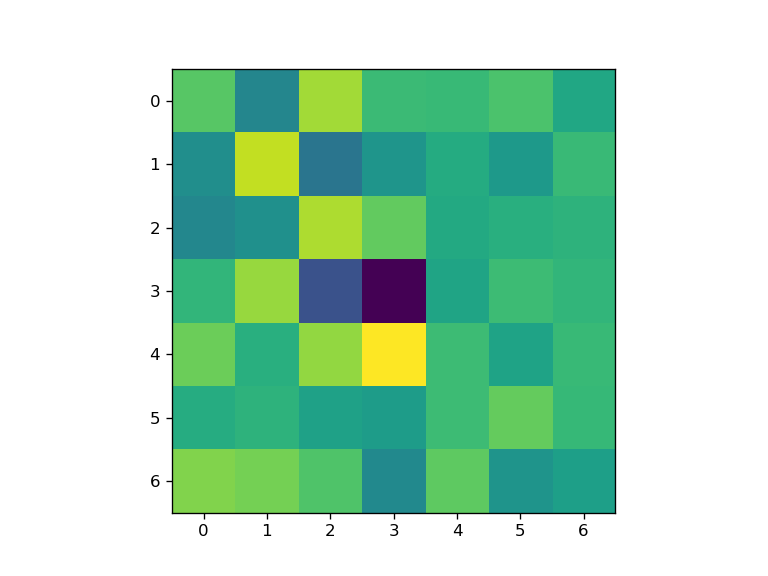

In [30]:
plt.figure()
plt.imshow(image)

In [22]:
np.nanmedian(image)

0.9400983432035162

In [23]:
np.nansum(abs(image))

117.16682337098882

In [24]:
np.nanmedian(psf.image_residual)

0.048603362130474004

In [31]:
print('ap ',tess.lc[1,ind])
print('psf ',psf.flux, 'pm',psf.eflux)

ap  -1.9292187169218629
psf  -37.203833728126675 pm 1.267244028125508


<IPython.core.display.Javascript object>


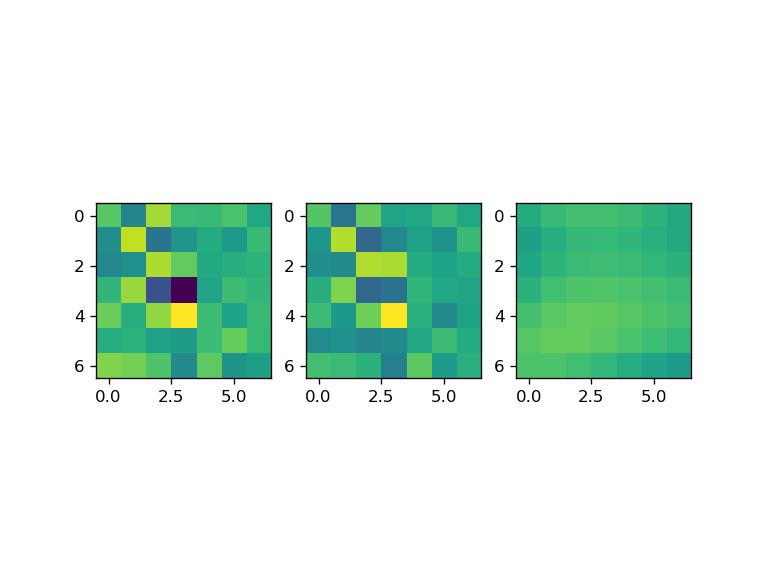

In [32]:
vmin = np.min(image)
vmax = np.max(image)
plt.figure()
plt.subplot(131)
plt.imshow(image,vmin=vmin,vmax=vmax)
plt.subplot(132)
plt.imshow(psf.image_residual,vmin=vmin,vmax=vmax)
plt.subplot(133)
plt.imshow(psf.surface,vmin=vmin,vmax=vmax)

<IPython.core.display.Javascript object>


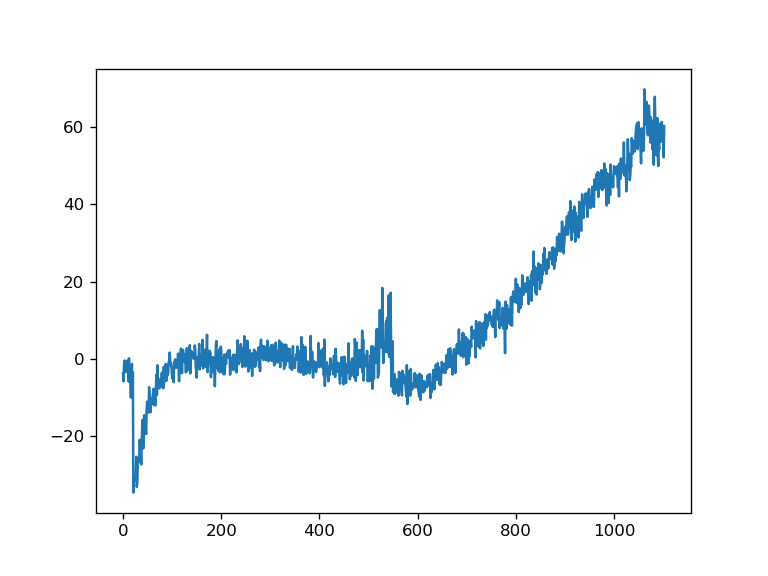

In [452]:
plt.figure()
plt.plot(tess.lc[1])

In [437]:
mask = np.zeros_like(psf.psf)
mask[psf.psf > np.nanpercentile(psf.psf,90)] = 1

<IPython.core.display.Javascript object>


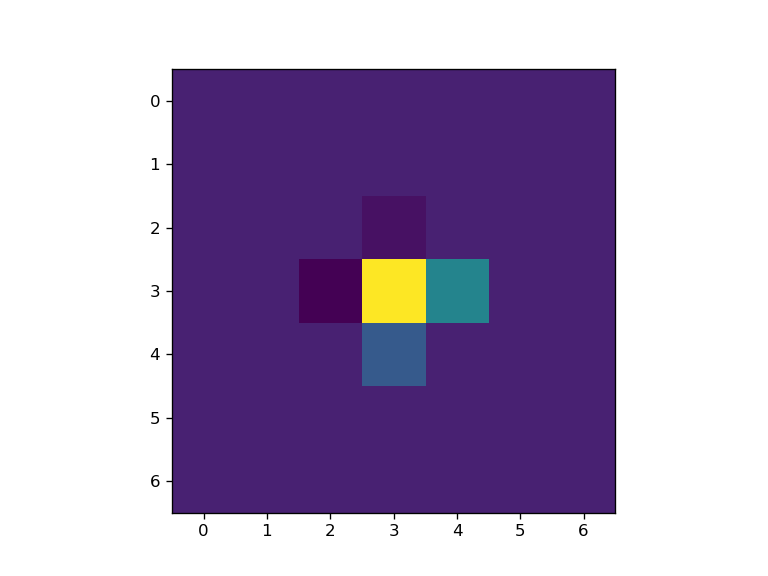

In [438]:
plt.figure()
plt.imshow(mask*cutouts[ind])

In [440]:
np.nansum(mask*cutouts[ind]) * 1.1

33.90180463973528

<IPython.core.display.Javascript object>


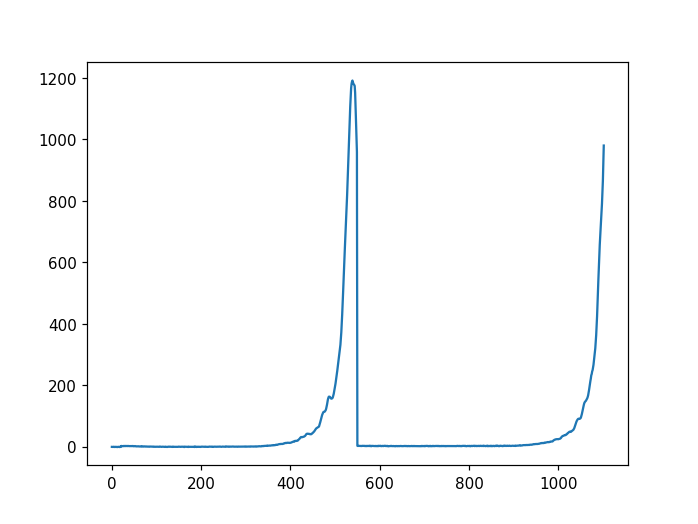

In [365]:
plt.figure()
plt.plot(tess.bkg[:,45,45])

-11.957300234051083

In [29]:
image = cutouts[0]
poly_order = 2
num_coeffs = (poly_order + 1) * (poly_order + 2) // 2
coeff = np.zeros(num_coeffs + 1)

x = np.arange(image.shape[1])
y = np.arange(image.shape[0])
yy,xx = np.meshgrid(y,x)
plane_coeff = coeff[1:]
s = polynomial_surface(xx,yy,plane_coeff,len(plane_coeff))

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [76]:
order = poly_order 
plane_coeff = [0., 0., 0., 0., 0., 0.]
z = np.zeros_like(xx,dtype=float)
ind = 0
for i in range(order + 1):
    for j in range(order + 1 - i):
        z += plane_coeff[ind] * (xx ** i) * (yy ** j)
        ind += 1

In [77]:
z

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [46]:
z

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [43]:
coeff[ind] * (xx ** i) * (yy ** j)

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [61]:
a = np.arange(5)

In [63]:
a[1:]

array([1, 2, 3, 4])